In [1]:
import requests
import math
import matplotlib.pyplot as plt
import shutil
import os
from getpass import getpass
from PIL import Image, UnidentifiedImageError
from requests.exceptions import HTTPError
from io import BytesIO
from pathlib import Path
import torch
import pytorch_lightning as pl
from huggingface_hub import HfApi, HfFolder, Repository
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTForImageClassification

In [2]:
DATA_DIR = "book-covers"

CATEGORIES = next(os.walk(DATA_DIR), (None, None, []))[1]
print(CATEGORIES)

['Art-Photography', 'Biography', 'Business-Finance-Law', 'Childrens-Books', 'Computing', 'Crafts-Hobbies', 'Crime-Thriller', 'Dictionaries-Languages', 'Entertainment', 'Food-Drink', 'Graphic-Novels-Anime-Manga', 'Health', 'History-Archaeology', 'Home-Garden', 'Humour', 'Medical', 'Mind-Body-Spirit', 'Natural-History', 'Personal-Development', 'Poetry-Drama', 'Reference', 'Religion', 'Romance', 'Science-Fiction-Fantasy-Horror', 'Science-Geography', 'Society-Social-Sciences', 'Sport', 'Stationery', 'Teaching-Resources-Education', 'Technology-Engineering', 'Teen-Young-Adult', 'Transport', 'Travel-Holiday-Guides']


In [3]:
data_dir = Path('book-covers')

In [4]:
ds = ImageFolder(data_dir)
indices = torch.randperm(len(ds)).tolist()
n_val = math.floor(len(indices) * .15)
train_ds = torch.utils.data.Subset(ds, indices[:-n_val])
val_ds = torch.utils.data.Subset(ds, indices[-n_val:])

Preview examples of books in each category.

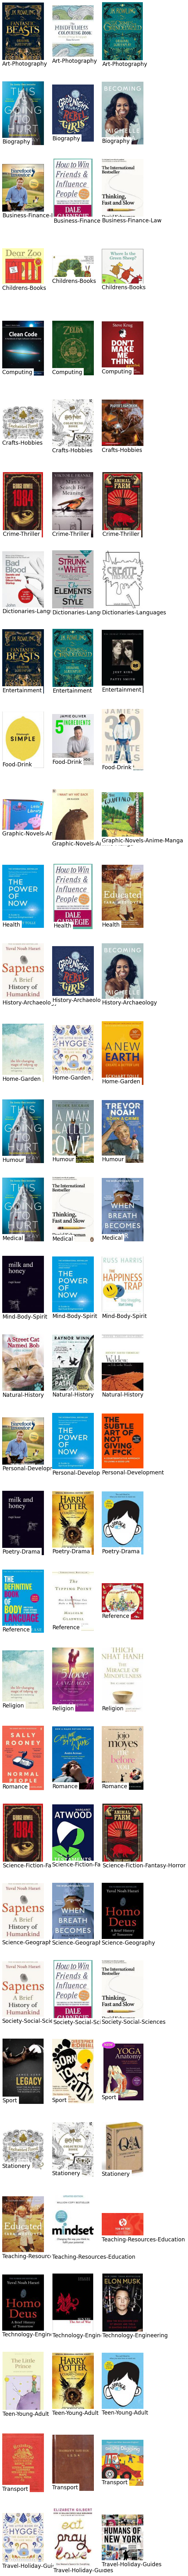

In [22]:
plt.figure(figsize=(8,150))
num_examples_per_class = 3
i = 1
for class_idx, class_name in enumerate(ds.classes):
    folder = ds.root / class_name
    for image_idx, image_path in enumerate(sorted(folder.glob('*'))):
        if image_path.suffix in ds.extensions:
            image = Image.open(image_path)
            plt.subplot(len(ds.classes), num_examples_per_class, i)
            ax = plt.gca()
            ax.set_title(
                class_name,
                size='xx-large',
                pad=5,
                loc='left',
                y=0,
                backgroundcolor='white'
            )
            ax.axis('off')
            plt.imshow(image)
            i += 1

            if image_idx + 1 == num_examples_per_class:
                break

In [5]:
label2id = {}
id2label = {}

for i, class_name in enumerate(ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name

In [6]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor
 
    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings 

Initiate Feature Extractor, Model, Data Loaders

In [12]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)
collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=8, collate_fn=collator,  shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collator)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with the book cover dataset

In [8]:
class Classifier(pl.LightningModule):

    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.val_acc = Accuracy()

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"train_loss", outputs.loss)
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"val_loss", outputs.loss)
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        self.log(f"val_acc", acc, prog_bar=True)
        return outputs.loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [14]:
pl.seed_everything(42)
classifier = Classifier(model, lr=2e-5)
trainer = pl.Trainer(gpus=1, precision=16, max_epochs=4)
trainer.fit(classifier, train_loader, val_loader)

Global seed set to 42
e:\Program Files\miniconda3\envs\miniconda\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                      | Params
------------------------------------------------------
0 | model   | ViTForImageClassification | 85.8 M
1 | val_acc | Accuracy                  | 0     
------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
171.648   Total esti

Sanity Checking: 0it [00:00, ?it/s]

e:\Program Files\miniconda3\envs\miniconda\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:230: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
e:\Program Files\miniconda3\envs\miniconda\lib\site-packages\pytorch_lightning\core\module.py:555: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=self.device)
e:\Program Files\miniconda3\envs\miniconda\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:230: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=4` reached.


In [15]:
val_batch = next(iter(val_loader))
outputs = model(**val_batch)
print('Preds: ', outputs.logits.softmax(1).argmax(1))
print('Labels:', val_batch['labels']) 

Preds:  tensor([ 9,  2,  6,  2, 22, 26, 17,  7])
Labels: tensor([29, 15, 22, 12,  6,  0,  5,  4])


In [27]:
saved_model_dir = 'fine_tuned_models'

In [29]:
model.save_pretrained(saved_model_dir)

In [33]:
feature_extractor.save_pretrained(saved_model_dir)

In [37]:
trainer.logged_metrics

{'train_loss': tensor(1.8105),
 'val_loss': tensor(2.5567),
 'val_acc': tensor(0.2568)}